In [ ]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=替换为自己的key

In [29]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

/opt/anaconda3/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-08 21:45:27.505093: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-08 21:45:27.535958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 21:45:28.138629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [2]:
!pip list|grep langchain-openai

langchain-openai                                  0.1.20


In [3]:
import os
import pandas as pd

from langchain_community.vectorstores import Chroma

In [5]:
expr_version = 'retrieval_v1_bge_ft'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 文档处理

## 文档加载

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

In [7]:
loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

## 文档切分

In [8]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [9]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


## 向量化

In [10]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain_community.vectorstores import Chroma
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [11]:
from tqdm.auto import tqdm
import shutil

vector_db_dict = {}

emb_names = [
    'bge_large',
    'bge_large_finetune'
]
model_paths = [
    # 如果已经下载到本地，可以替换为本地路径
    'BAAI/bge-large-zh-v1.5',
    'stevenluo/bge-large-zh-v1.5-ft-v4'
]

for name, model_path in tqdm(zip(emb_names, model_paths), total=len(emb_names)):
    # 确保结果可复现性
    persist_directory = os.path.join(expr_dir, 'chroma', name)
    shutil.rmtree(persist_directory, ignore_errors=True)
    
    embeddings = get_embeddings(model_path)
    vector_db_dict[name] = Chroma.from_documents(
        splitted_docs,
        embedding=embeddings,
        persist_directory=persist_directory
    )

  0%|          | 0/2 [00:00<?, ?it/s]

# 检索

In [12]:
def retrieve(vector_db, query: str, k=5):
    return vector_db.similarity_search(query, k=k)

## 计算检索准确率

In [13]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [14]:
def get_hit_stat_df(vector_db, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        retriever = vector_db.as_retriever(search_kwargs={'k': k})
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve(vector_db, question, k=k)
            chunks = retriever.get_relevant_documents(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

In [15]:
hit_stat_dfs = []
for key in vector_db_dict:
    vector_db = vector_db_dict[key]
    hit_stat_df = get_hit_stat_df(vector_db)
    hit_stat_df['emb_model'] = key
    hit_stat_dfs.append(hit_stat_df)

  0%|          | 0/8 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


  0%|          | 0/8 [00:00<?, ?it/s]

In [16]:
all_hit_stat_df = pd.concat(hit_stat_dfs)

这个结果，与baseline中的结果，是不一样的

In [17]:
all_hit_stat_df.groupby(['emb_model', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,emb_model,top_k,hit_rate
0,bge_large,1,0.462366
1,bge_large,2,0.591398
2,bge_large,3,0.688172
3,bge_large,4,0.774194
4,bge_large,5,0.806452
5,bge_large,6,0.817204
6,bge_large,7,0.838710
7,bge_large,8,0.849462
8,bge_large_finetune,1,0.548387
9,bge_large_finetune,2,0.698925


<Axes: xlabel='top_k', ylabel='hit'>

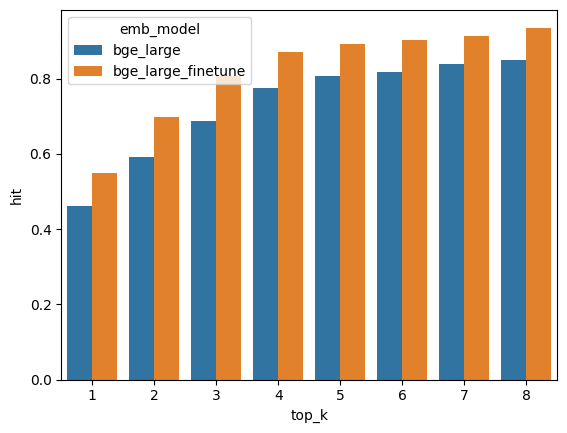

In [18]:
import seaborn as sns

sns.barplot(x='top_k', y='hit', hue='emb_model', data=all_hit_stat_df, errorbar=None)

# 问答全流程

In [20]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [21]:
llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。我可以回答各种领域的问题、提供信息查询、解释概念、辅助学习等。请随时告诉我您需要帮助的内容，我会尽力提供支持。'

In [22]:
def rag(vector_db, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    chunks = retrieve(vector_db, query, k=n_chunks)
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), chunks

In [23]:
print(rag(vector_db_dict['bge_large'], '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


## 预测

In [24]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, vector_db, n_chunks):
    prediction_df = prediction_df.copy()

    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(vector_db, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

检索片段数为4的

In [25]:
bge_vanilla_4_pred_df = predict(prediction_df, vector_db_dict['bge_large'], n_chunks=4)
bge_ft_4_pred_df = predict(prediction_df, vector_db_dict['bge_large_finetune'], n_chunks=4)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

检索片段数为3的

In [26]:
bge_vanilla_pred_df = predict(prediction_df, vector_db_dict['bge_large'], n_chunks=3)
bge_ft_pred_df = predict(prediction_df, vector_db_dict['bge_large_finetune'], n_chunks=3)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [28]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)


def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

## 知识片段数为3

In [29]:
bge_vanilla_pred_df['raw_score'] = evaluate(bge_vanilla_pred_df)
bge_ft_pred_df['raw_score'] = evaluate(bge_ft_pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
bge_vanilla_pred_df['raw_score'].unique(), bge_ft_pred_df['raw_score'].unique()

(array(['是', '否'], dtype=object), array(['是', '否'], dtype=object))

In [35]:
bge_vanilla_pred_df['score'] = (bge_vanilla_pred_df['raw_score'] == '是').astype(int)
bge_ft_pred_df['score'] = (bge_ft_pred_df['raw_score'] == '是').astype(int)

In [36]:
bge_vanilla_pred_df['score'].mean(), bge_ft_pred_df['score'].mean()

(0.72, 0.74)

准确率

In [37]:
bge_vanilla_pred_df[bge_vanilla_pred_df['qa_type'] == 'detailed']['score'].mean(), bge_ft_pred_df[bge_ft_pred_df['qa_type'] == 'detailed']['score'].mean()

(0.6989247311827957, 0.7311827956989247)

In [38]:
bge_vanilla_pred_df['retrieval_hit'] = bge_vanilla_pred_df.apply(lambda row: int(row['uuid'] in [doc.metadata['uuid'] for doc in row['chunks']]), axis=1)
bge_ft_pred_df['retrieval_hit'] = bge_ft_pred_df.apply(lambda row: int(row['uuid'] in [doc.metadata['uuid'] for doc in row['chunks']]), axis=1)

## 知识片段数为4

In [40]:
bge_vanilla_4_pred_df['raw_score'] = evaluate(bge_vanilla_4_pred_df)
bge_ft_4_pred_df['raw_score'] = evaluate(bge_ft_4_pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [41]:
bge_vanilla_4_pred_df['raw_score'].unique(), bge_ft_4_pred_df['raw_score'].unique()

(array(['是', '否'], dtype=object), array(['是', '否'], dtype=object))

In [44]:
bge_vanilla_4_pred_df['score'] = (bge_vanilla_4_pred_df['raw_score'] == '是').astype(int)
bge_ft_4_pred_df['score'] = (bge_ft_4_pred_df['raw_score'] == '是').astype(int)

In [45]:
bge_vanilla_4_pred_df['score'].mean(), bge_ft_4_pred_df['score'].mean()

(0.7, 0.56)